# Mitre Data

In this playbook we will be looking at collecting, analysing Mitre data.  
We will also look to standardise the output of the data in such a way that it can be merged with other data sources.  

## Mitre Attack Techniques

We will be using the Mitre Attack framework as our way to standardise techniques across all data sources.  
For a webpage showing this you can follow [this link](https://attack.mitre.org/matrices/enterprise/).  
In order to work with this progromatically we will be using the same data in JSON format from [here](https://github.com/mitre/cti/blob/master/enterprise-attack/enterprise-attack.json).

In [1]:
import requests
import json
import pandas as pd
import os.path

r = requests.get("https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json").json()

if not os.path.isfile("Mitre_data/MITRE_Techniques.json"):
    with open("Mitre_data/MITRE_Techniques.json", "w") as file:
        json.dump(r, file, indent=4)

with open('Mitre_data/MITRE_Techniques.json','r') as f:
    data = json.loads(f.read())

df_tech = pd.json_normalize(data, record_path =['objects'])
df_tech.head()

,type,modified,name,x_mitre_data_sources,x_mitre_version,created,x_mitre_permissions_required,x_mitre_platforms,x_mitre_is_subtechnique,id,...,identity_class,aliases,x_mitre_aliases,labels,x_mitre_shortname,tactic_refs,x_mitre_collection_layers,x_mitre_data_source_ref,definition_type,definition.statement
0,attack-pattern,2020-03-20T15:56:55.022Z,/etc/passwd and /etc/shadow,"[Command: Command Execution, File: File Access]",1.0,2020-02-11T18:46:56.263Z,[root],[Linux],True,attack-pattern--d0b4fcdb-d67d-4ed2-99ce-788b12...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,attack-pattern,2021-07-28T01:04:39.141Z,ARP Cache Poisoning,"[Network Traffic: Network Traffic Content, Net...",1.1,2020-10-15T12:05:58.755Z,[User],"[Linux, Windows, macOS]",True,attack-pattern--cabe189c-a0e3-4965-a473-dcff00...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,attack-pattern,2021-06-07T19:23:33.039Z,AS-REP Roasting,[Active Directory: Active Directory Credential...,1.0,2020-08-24T13:43:00.028Z,[User],[Windows],True,attack-pattern--3986e7fd-a8e9-4ecb-bfc6-559208...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,attack-pattern,2020-07-22T21:36:52.825Z,Abuse Elevation Control Mechanism,"[Process: Process Metadata, Process: Process C...",1.0,2020-01-30T13:58:14.373Z,"[Administrator, User]","[Linux, macOS, Windows]",False,attack-pattern--67720091-eee3-4d2d-ae16-826456...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,attack-pattern,2021-10-17T14:51:49.334Z,Access Token Manipulation,"[Process: Process Creation, Process: Process M...",2.0,2017-12-14T16:46:06.044Z,"[User, Administrator]",[Windows],False,attack-pattern--dcaa092b-7de9-4a21-977f-7fcb77...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Within this JSON there are 15886 objects.  
These are broken down into the following high level catergories.  

In [2]:
a = df_tech['type'].unique()
print(sorted(a))

['attack-pattern', 'course-of-action', 'identity', 'intrusion-set', 'malware', 'marking-definition', 'relationship', 'tool', 'x-mitre-data-component', 'x-mitre-data-source', 'x-mitre-matrix', 'x-mitre-tactic']


The objects of intrest to us are attack-pattern as these relate to the techniques in the Mitre Attak Matrix.  
So we can clean up our dataframe a little.  

In [3]:
df_tech = df_tech[df_tech['type'] == "attack-pattern" ]
df_tech.reset_index().to_json("Mitre_data/MITRE_Techniques_edited.json",orient='records')
a = df_tech['type'].unique()
print(sorted(a))

['attack-pattern']


## Mitre Groups

We will now look into collecting data from Mitre regarding threat actor groups.  
For a webpage showing this you can follow [this link](https://attack.mitre.org/groups/).  
There does not seem to be an offical location for this data in a format that is suitable for progrom,atic use.  
This means we will have to scrape the data and make it so.  

In [4]:
from bs4 import BeautifulSoup
import logging
import sys

if not os.path.isfile("Mitre_data/MITRE_Groups.json"):
    page = requests.get("https://attack.mitre.org/groups/").text
    soup = BeautifulSoup(page, "html.parser")
    table = soup.find("table", class_="table table-bordered table-alternate mt-2")
    df = pd.read_html(str(table))[0]
    ids = df["ID"].tolist()
    results = []
    no_ttps = ["G0017", "G0030", "G0055"]
    for i in ids:
        r = requests.get("https://attack.mitre.org/groups/" + i + "/" + i + "-enterprise-layer.json")
        if r.status_code == 200:
            results.append(r.json())
        if r.status_code == 404:
            r = requests.get("https://attack.mitre.org/groups/" + i + "/" + i + "-mobile-layer.json")
            if r.status_code == 200:
                results.append(r.json())
            if r.status_code == 404:
                if i in no_ttps:
                    pass
                else:
                    logging.error("A request to Mitre Groups Failed for ID " + i)
                    sys.exit(1)
    with open("Mitre_data/MITRE_Groups.json", "w") as file:
        json.dump(results, file, indent=4)

df_group = pd.read_json("Mitre_data/MITRE_Groups.json", orient='records')

df_group.head()

,description,name,domain,versions,techniques,gradient,legendItems
0,"Enterprise techniques used by admin@338, ATT&C...",admin@338 (G0018),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'techniqueID': 'T1087', 'showSubtechniques':...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by admin@338', 'color': '#66b..."
1,Enterprise techniques used by Ajax Security Te...,Ajax Security Team (G0130),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'techniqueID': 'T1555', 'showSubtechniques':...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by Ajax Security Team', 'colo..."
2,"Enterprise techniques used by Andariel, ATT&CK...",Andariel (G0138),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'score': 1, 'techniqueID': 'T1005', 'showSub...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by Andariel', 'color': '#66b1..."
3,"Enterprise techniques used by APT-C-36, ATT&CK...",APT-C-36 (G0099),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'techniqueID': 'T1059', 'showSubtechniques':...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by APT-C-36', 'color': '#66b1..."
4,"Enterprise techniques used by APT1, ATT&CK gro...",APT1 (G0006),enterprise-attack,"{'layer': '4.3', 'attack': '10', 'navigator': ...","[{'techniqueID': 'T1087', 'showSubtechniques':...","{'colors': ['#ffffff', '#66b1ff'], 'minValue':...","[{'label': 'used by APT1', 'color': '#66b1ff'}]"


We now have our to key pieces of data from Mitre, that being the techniques and the threat actors.  
This means we can start analysing this data by itself.  

## Analysis

We can start by ranking the techniques by how often they are seen across our threat actors.

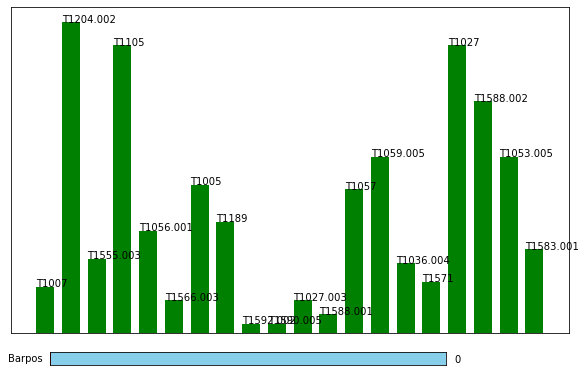

In [21]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

plt.rcParams['figure.figsize'] = [100, 20]

results = {}
for row in df_group["techniques"].tolist():
    for dict in row:
        if dict["showSubtechniques"] == True and "score" not in dict:
            pass
        elif dict["showSubtechniques"] == True and "score" in dict:
            if dict["techniqueID"] in results:
                results[dict["techniqueID"]] += 1
            else:
                results[dict["techniqueID"]] = 1
        elif dict["showSubtechniques"] == False:
            if dict["techniqueID"] in results:
                results[dict["techniqueID"]] += 1
            else:
                results[dict["techniqueID"]] = 1
           

fig,ax=plt.subplots(figsize=(10,6))        
        
x = list(results.keys())

y = list(results.values())

N=20

def bar(pos):
    pos = int(pos)
    ax.clear()
    if pos+N > len(x): 
        n=len(x)-pos
    else:
        n=N
    X=x[pos:pos+n]
    Y=y[pos:pos+n]
    ax.bar(X,Y,width=0.7,align='edge',color='green',ecolor='black')

    for i,txt in enumerate(X):
       ax.annotate(txt, (X[i],Y[i]))

    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

barpos = plt.axes([0.18, 0.05, 0.55, 0.03], facecolor="skyblue")
slider = Slider(barpos, 'Barpos', 0, len(x)-N, valinit=0)
slider.on_changed(bar)

bar(10)

plt.show()              

# present this visualy 

# roll up the sub-techniques and present this again

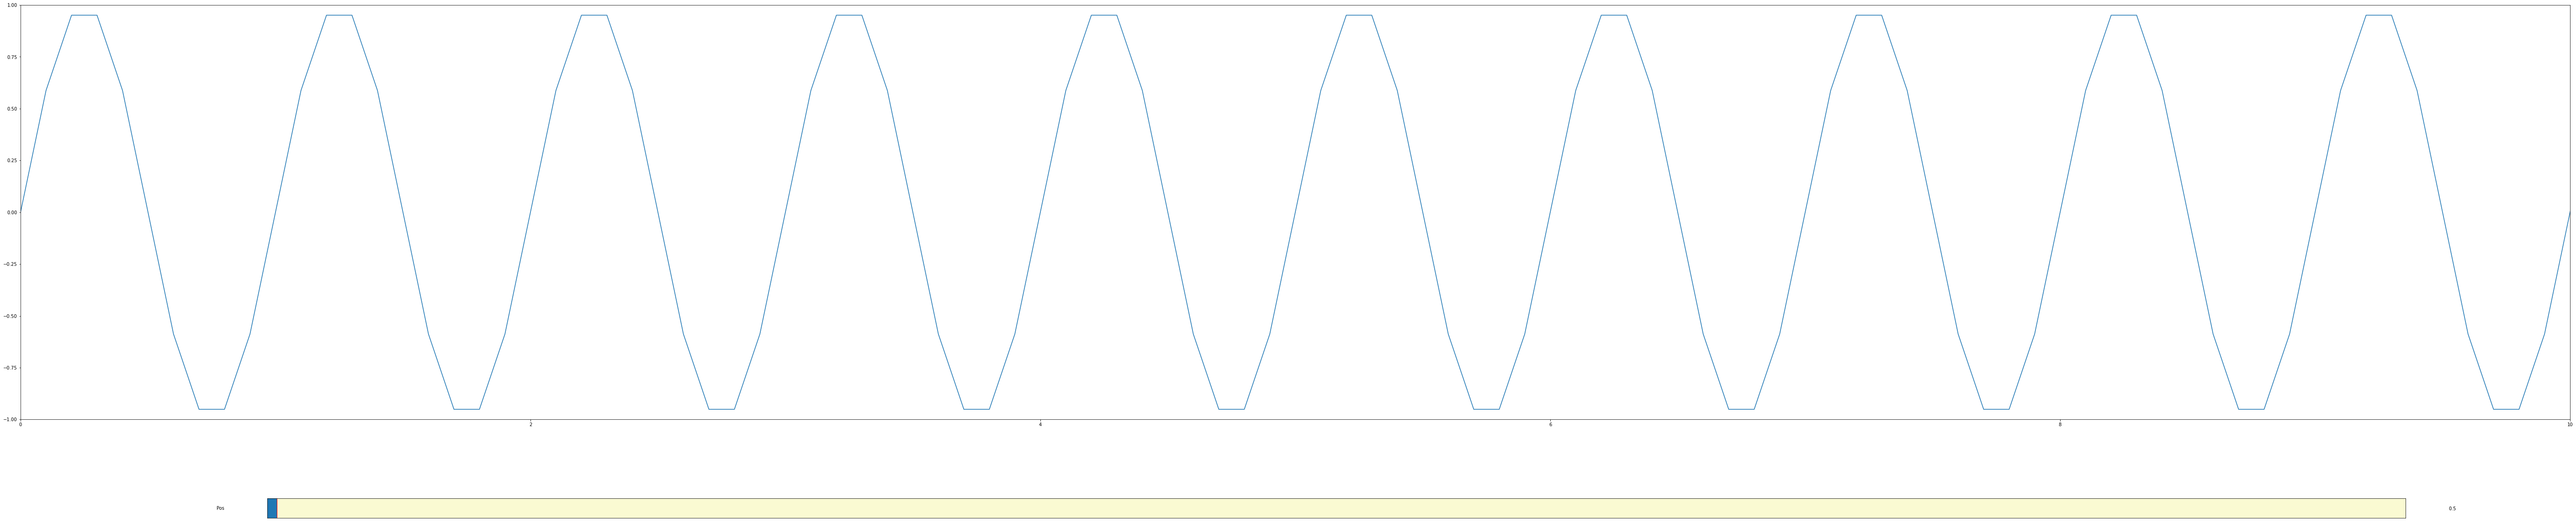

In [19]:
import numpy as np

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

t = np.arange(0.0, 100.0, 0.1)
s = np.sin(2*np.pi*t)
l, = plt.plot(t,s)
plt.axis([0, 10, -1, 1])

axcolor = 'lightgoldenrodyellow'
axpos = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor=axcolor)

spos = Slider(axpos, 'Pos', 0.1, 90.0)

def update(val):
    pos = spos.val
    ax.axis([pos,pos+10,-1,1])
    fig.canvas.draw_idle()

spos.on_changed(update)

plt.show()